# Modeling & Fitting

Jalankan kode di bawah ini untuk update modul prediksicovidjatim.
1. Klik bagian di bawah ini
2. Tekan "Y" di keyboard
3. Tekan Shift + Enter
4. Tunggu hingga muncul tulisan di bawahnya. Kalau sukses, di paling bawah, atau di atas kotak merah akan ada tulisan "Successfully installed prediksicovidjatim". Kotak merah hanya warning, bukan error.
5. Tekan lagi bagian di bawah ini (Di luar area kode)
6. Tekan "M" di keyboard
7. Tekan Shift + Enter
8. Restart & Run All

!pip install --upgrade --force-reinstall -e git://github.com/R-N/prediksicovidjatim-core.git#egg=prediksicovidjatim-core

In [1]:
import os
import sys
#sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from prediksicovidjatim import util, config, database
from prediksicovidjatim.data.model import ModelDataRepo
from prediksicovidjatim.data.model.entities import *

database.init()
ModelDataRepo.init_weights()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KAB. SAMPANG"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

### Make Model

In [3]:
from prediksicovidjatim.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [4]:
used_datasets = [
    #"infectious", 
    "critical_cared", 
    "infectious_all", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [5]:
varying_init = [
    "death_rate_over",
    "exposed_rate_over", 
    "kapasitas_rs_mul", 
    "test_coverage_max", 
    "test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [6]:
varying_now = [
    #"death_rate_over",
    #"exposed_rate_over", 
    #"kapasitas_rs_mul", 
    #"test_coverage_max", 
    #"test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

Fitting dilakukan dalam 2 tahap:
1. Fitting awal. Fit hanya dilakukan sekali. Lakukan hingga kurva cukup baik.
2. Fitting + Test. Fit dilakukan 4 kali dengan 3 fit pertama adalah fit dengan dataset yang dibagi menjadi train set dan test set. 

Variable first_time di bawah menunjukkan fitting mana yang akan dilakukan. 
1. Jika melakukan fitting awal (1), first_time = True
2. Jika melakukan fitting + test (2), first_time = False

Perhatikan besar kecilnya.

In [7]:
first_time = True

In [8]:
first_time = first_time or not kabko.scored
if first_time:
    test_splits = []
else:
    test_splits = [3]

In [9]:
result = mod.fit(method="leastsq", test_splits=test_splits, unvary=unvary, first_time=first_time)
result.fit_result.message

'Fit succeeded. Could not estimate error-bars.'

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [10]:
result.fit_result.params

name,value,standard error,relative error,initial value,min,max,vary
days,79.0000000,0.00000000,(0.00%),79,-inf,inf,False
population,989001.000,0.00000000,(0.00%),989001,-inf,inf,False
infectious_rate,0.33333333,0.03333333,(10.00%),0.3333333333333333,0.07142857,0.33333333,True
critical_chance,0.50000000,0.05000000,(10.00%),0.031578947368421054,0.01000000,0.50000000,True
critical_rate,0.14285714,0.01428571,(10.00%),0.1,0.08333333,0.14285714,True
recovery_rate_normal,0.11111111,0.00000000,(0.00%),0.1111111111111111,-inf,inf,False
recovery_rate_critical,0.15384615,0.00000000,(0.00%),0.15384615384615385,-inf,inf,False
death_chance_normal,0.00500339,5.0034e-04,(10.00%),3.3333333333333335,0.00500000,3.33333333,True
death_rate_normal,0.12638940,0.01263894,(10.00%),0.13333333333333333,0.10000000,0.20000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


### Predict

In [11]:
values = dict(result.fit_result.values)
values["days"] += 30
values["days"]

109

In [12]:
model_result = mod.model(**values)

### Plot!

In [13]:
from prediksicovidjatim.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [14]:
length = kabko.data_count + result.outbreak_shift
length

79

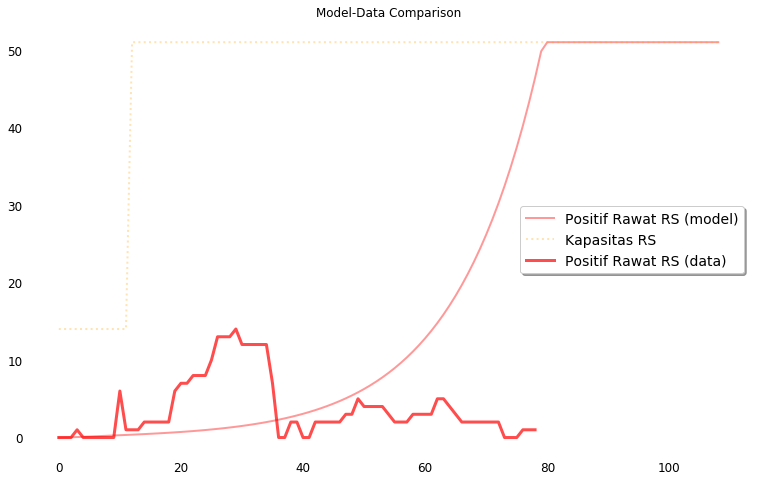

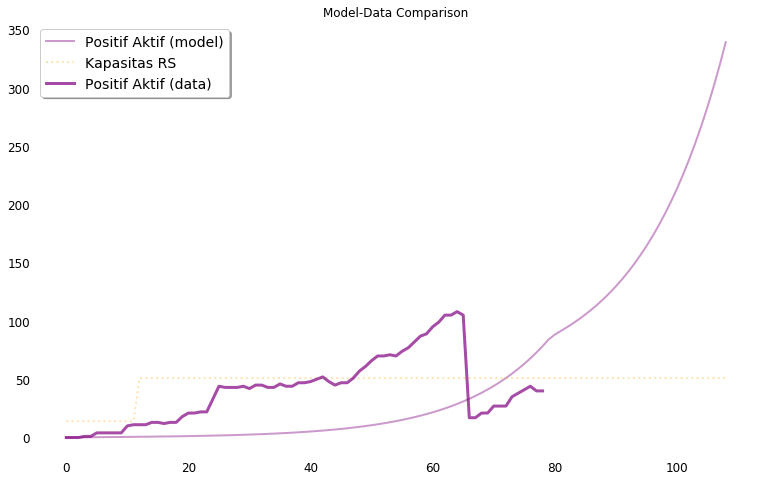

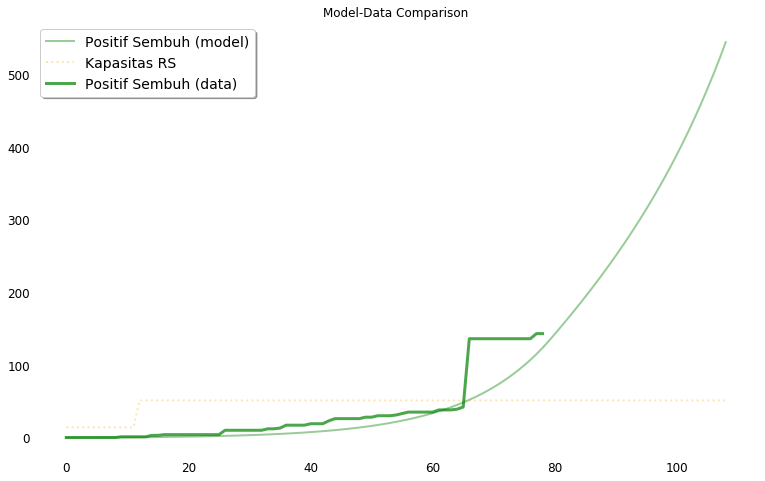

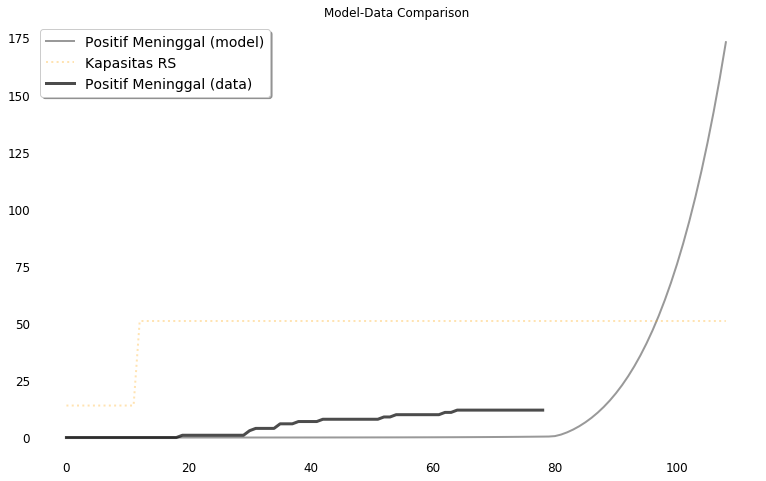

In [15]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

plotter.plot(plotter.plot_main_lite);

plotter.plot(plotter.plot_daily_lite);

plotter.plot(plotter.plot_r0);

plotter.plot(plotter.plot_mortality_rate);

plotter.plot(plotter.plot_over);

plotter.plot(plotter.plot_dead);

plotter.plot(plotter.plot_healthcare);

### Model Scores

In [16]:
print("Last fit scores")
result.fit_scorer.report()
print()

Last fit scores
Varying Parameters: 6
Residual Mean (~0): [-4.78678258 26.24445337 13.43432612  5.69965766]
Residual Median (~0): [-1.53382378 39.05118865  7.39281529  6.975493  ]
Max Error (~0): [45.39363502 80.03567105 84.09735153 11.85184341]
MAE (~0): [ 9.04381142 33.65380467 13.87152828  5.70013446]
MSE (~0): [ 196.35924965 1619.06076305  598.67849448   54.0252181 ]
RMSE (~0): [14.01282447 40.23755414 24.46790744  7.3501849 ]
RMSLE (~0): [1.49368339 1.74169301 0.64964809 1.73453473]
Explained Variance: [-10.50053387  -0.14222946   0.80881378   0.03313157]
R2 (~1): [-12.01982573  -0.98791778   0.7263037   -1.42513512]
Adjusted R2 (~1): [-13.10481121  -1.15357759   0.70349567  -1.62722971]
SMAPE (~0): [0.68386533 0.69744276 0.41658164 0.97248799]
MASE (~0): [1.04991664 0.99360524 0.90287201 0.98646232]
Chi Square: [15512.380722402278, 127905.80028087644, 47295.60106408399, 4267.992230138906]
Reduced Chi Square: [212.4983660603052, 1752.134250422965, 647.8849460833424, 58.46564698820

In [17]:
print("Last fit scores flat")
result.fit_scorer.flatten().report()
print()

Last fit scores flat
Varying Parameters: 6
Residual Mean (~0): [10.14791364]
Residual Median (~0): [6.00708517]
Max Error (~0): [84.09735153]
MAE (~0): [15.56731971]
MSE (~0): [617.03093132]
RMSE (~0): [24.84010731]
RMSLE (~0): [1.47438445]
Explained Variance: [0.50580764]
R2 (~1): [0.40680573]
Adjusted R2 (~1): [0.3952874]
SMAPE (~0): [0.69259443]
MASE (~0): [1.04991664]
Chi Square: [194981.77429750163]
Reduced Chi Square: [628.9734654758117]
AIC: [2042.2744528061417]
AICc: [2042.5462974663358]
BIC: [2064.808906087663]
Durbin-Watson: [0.11201975]
Residual Normal Test Shapiro p (p>a): [4.45231434e-16]
Residual Runs Test p (p>0.5): [1.98940624e-55]
F-Test Overall Significance p (p<a): [3.06966455e-17]
F-Test pred-data p (p>a): [3.22284215e-06]
F-Test residual-zero p (p>a): [9.04899339e-15]
KS-Test pred-data p (p>a): [9.80891696e-13]
KS-Test residual-normal p (p>a): [2.6171352e-99]
Prediction Interval p (p<a): [0.98734177]



In [18]:
if result.test_scorer:
    print("Test scores")
    result.test_scorer.report()
    print()

In [19]:
if result.test_scorer:
    print("Test scores flat")
    result.test_scorer.flatten().report()
    print()

### Save Params

Run code below ONLY if you want to save the parameters.

In [20]:
ModelDataRepo.save_fitting_result(result)